### <b style="color: #0eab81">RNN을 사용한 문장 생성</b>

##### https://github.com/karpathy/char-rnn/tree/master/data/tinyshakespeare 에서 input.txt 다운로드

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm

In [2]:
from ck.env import get_device

system_device = get_device()
print(system_device)

mps


In [3]:
import string

all_chars = string.printable
dict_vocab = {c:i for i, c in enumerate(all_chars)}
size_vocab = len(dict_vocab)


def str2ints(s, dict_vocab):
    return [dict_vocab[c] for c in s]


def ints2str(a, list_vocab):
    return ''.join([list_vocab[i] for i in a])

In [4]:
class ShakespeareDataset(Dataset):
    def __init__(self, path, dict_vocab, chunk_size=200):
        self.dict_vocab = dict_vocab
        data = str2ints(open(path).read().strip(), dict_vocab)
        # chunk_size 단위의 크기로 data를 쪼개서 tuple로 만든다
        data = torch.tensor(data, dtype=torch.int64).split(chunk_size)
        
        # 200이 안되는 사이즈는 버림(padding은 안하는가)
        if len(data[-1]) < chunk_size:
            data = data[:-1]
            
        self.data = data
        self.n_chunks = len(self.data)
        
    def __len__(self):
        return self.n_chunks
    
    def __getitem__(self, idx):
        return self.data[idx]
        

In [5]:
path_data = 'data/tinyshakespeare/input.txt'
ds = ShakespeareDataset(path_data, dict_vocab, chunk_size=200)
loader = DataLoader(ds, batch_size=32, shuffle=True)

In [6]:
class SequenceGenerationNet(nn.Module):
    def __init__(
        self,
        num_embeddings,
        embedding_dim=50,
        hidden_size=50,
        num_layers=1,
        dropout=.2,
        mode_test = False,
    ):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            num_layers,
            batch_first = True,
            dropout = dropout,
        )
        self.linear = nn.Linear(hidden_size, num_embeddings)
        self.mode_test = mode_test
        if self.mode_test:
            self.test()
        
    def forward(self, x, h0=None):
        if self.mode_test:
            print(x.shape)
        x = self.emb(x)
        if self.mode_test:
            print(x.shape)
        x, h = self.lstm(x, h0)
        if self.mode_test:
            print(x.shape)
        x = self.linear(x)
        if self.mode_test:
            print(x.shape)
        return x, h
    
    def test():
        # for test
        net = SequenceGenerationNet(size_vocab, 20)

        result = []

        sp = 'The King said '
        ints = str2ints(sp, dict_vocab)
        st = torch.tensor(ints, dtype=torch.int64)
        x0 = st.unsqueeze(0)

        o, (h_state, c_state) = net(x0)

        print(f'x0: {x0.shape}')
        print(f'o: {o.shape}')
        print(f'h_state: {h_state.shape}')
        print(f'c_state: {c_state.shape}')

        out_dist = o[:, -1].view(-1).exp()
        print(f'out_dist: {out_dist.shape}')
        print(f'out_last: {o[:, -1].view(-1)}')
        print(f'out_dist: {out_dist}')
        top_i = torch.multinomial(out_dist, 1)[0]

        result.append(top_i)

        print(result)

In [70]:
def generate_seq(net, start_phrase='The King said ', length=200, temperatur=.8, device='cpu'):
    net.eval()
    result = []
    
    start_tensor = torch.tensor(
        str2ints(start_phrase, dict_vocab),
        dtype=torch.int64
    ).to(device)
    
    x0 = start_tensor.unsqueeze(0)
    o, h = net(x0)
    out_dist = o[:, -1].view(-1).exp() # 음수를 제거하기 위해 사용하는 듯
    top_i = torch.multinomial(out_dist, 1)[0] # 다항분포를 사용하는데 다항분포를 몰라서 의미를 알수가 없다. softmax 방식을 써도 되는거 아닌가?
    # top_i = o[:, -1].max(1)[1] # 안된다 존나 안된다 시발 뭔 상황인지 모르겠다. 같은것만 반복해서 나옴
    result.append(top_i)
    
    for i in range(length):
        inp = torch.tensor([[top_i]], dtype=torch.int64)
        inp = inp.to(device)
        o, h = net(inp, h)
        out_dist = o.view(-1).exp()
        top_i = torch.multinomial(out_dist, 1)[0]
        # top_i = o[:, -1].max(1)[1]
        
        result.append(top_i)
        
    return start_phrase + ints2str(result, all_chars)

### <b style="color: #0eab81">Training</b>
1. x는 chunk문장의 첫번째에서 마지막 문자의 하나 앞 문자까지 이용,  
y는 2번째에서 마지막까지(x[:-1], x[1:])
2. nn.CrossEntropyLoss는 2D(batch, dim)의 예측값이고  
1D의 레이블 데이터만 사용할 수 있지만 이 RNN 모델에서는  
예측값이 3D(batch, step, dim)이고 레이블이 2D(batch, step)이므로  
view를 이용해서 batch와 step을 통합해서 전달한다  
**(난 이게 뭔소린지 도무지 이해를 못하겠다)**

In [67]:
from statistics import mean

import pandas as pd

net = SequenceGenerationNet(size_vocab, 20, 50, num_layers=2, dropout=.1)
net.to(system_device)
opt = optim.Adam(net.parameters())
loss_f = nn.CrossEntropyLoss()

with torch.no_grad():
    print(generate_seq(net, device=system_device))

df_history = pd.DataFrame(columns=['epoch', 'step', 'loss'])
for epoch in range(50):
    net.train()
    losses = []
    bar = tqdm(enumerate(loader), total=len(loader))
    for i, data in bar:
        bar.set_postfix({'epoch': epoch, 'step': i})
        x = data[:, :-1].to(system_device)
        y = data[:, 1:].to(system_device)
        
        net.zero_grad()
        y_pred, _ = net(x)
        loss = loss_f(y_pred.view(-1, size_vocab), y.view(-1))
        loss.backward()
        opt.step()
        losses.append(loss.item())
        df_history.loc[len(df_history)] = [epoch, i, loss.item()]
        
    # print(epoch, mean(losses))
    
with torch.no_grad():
        print(generate_seq(net, device=system_device))
    

The King said +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


100%|██████████| 175/175 [00:04<00:00, 43.60it/s, epoch=49, step=174]


The King said serlal yole till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till till


In [69]:
generate_seq(net, device=system_device)

"The King said tial, sacpnand try tay incusile dathes'arcratyer brgespasentytieriselss to nassy,, dangince fefl,ly, callinged's bsitpmisfelks: tintlalmsmersibess yre slare britilurn, selr yoless, beccessur arl entles"

<Axes: >

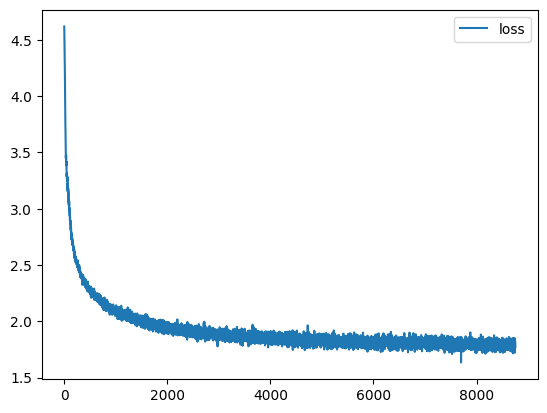

In [17]:
df_history.drop(['epoch', 'step'], axis=1).plot()

In [36]:
start_phrase = 'The King said '
st = torch.tensor(str2ints(start_phrase, dict_vocab), dtype=torch.int64).to(system_device)

x0 = st.unsqueeze(0)
o, h = net(x0)

In [57]:
o.shape

torch.Size([1, 14, 100])

In [65]:
o[:, -1].max(1)

torch.return_types.max(
values=tensor([5.4652], device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([29], device='mps:0'))

In [52]:
o[:, -1].max(1)[1]


tensor([29], device='mps:0')

In [35]:
print(result[0])
print(y_pred[0][0][29])

tensor(3.9855, device='mps:0', grad_fn=<SelectBackward0>)
tensor(3.9855, device='mps:0', grad_fn=<SelectBackward0>)
